# Setup

In [5]:
#Imports
import matplotlib as plt
import pandas as pd
import tensorflow as tf
import seaborn as sns
sns.set()
from tensorflow.keras import layers

print ("TensorFlow version: " + tf.__version__)

TensorFlow version: 1.12.0


In [2]:
#Load all data
data = pd.read_csv('data/all_annotations.tsv', sep='\t')

#Split it into labels and features
y = data[['chord']]
tx = data.drop(columns='chord')

# Data exploration

Most common chords


,chord
chord,
I,2672
V7,2087
V,1588
I6,1426
i,988
V65,854
V43,814
IV,765
V(64),701


Least common chords


,chord
chord,
V7(#7),1
V7(+#2),1
V7(119),1
V7(+2)/V,1
V7(+9)/iv,1
V7(+b2)/IV,1
V7(+b2)/V,1
V7(+b2)/VII,1
V7(+b2)/iv,1


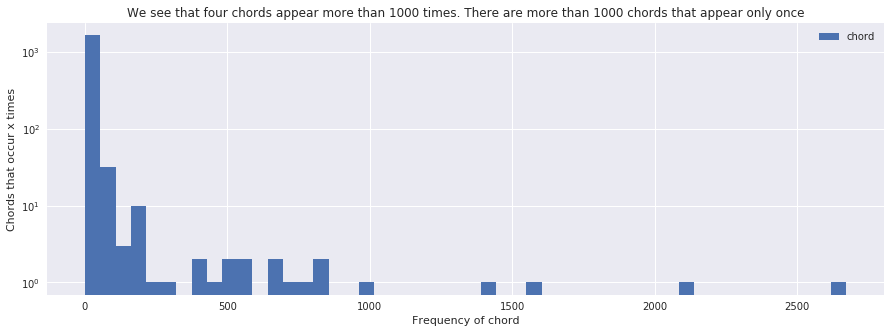

In [21]:
#Count how many times each chord appear
chord_dist = y.groupby('chord')['chord'].count()

#Sort them and make them into a dataframe
chord_dist = chord_dist.sort_values(ascending = False)
chord_dist = pd.DataFrame(chord_dist)

#Plot the distribution
ax = chord_dist.plot.hist(bins= 50, figsize = [15,5])
ax.semilogy()
ax.set_xlabel("Frequency of chord")
ax.set_ylabel("Chords that occur x times")
_=ax.set_title("We see that four chords appear more than 1000 times. There are more than 1000 chords that appear only once")

print("Most common chords")
display(chord_dist.head(10))
print("Least common chords")
display(chord_dist.tail(10))



# Model 

In [4]:
#Not yet doing anything important

model = tf.keras.Sequential()
# Adds a densely-connected layer with 64 units to the model:
model.add(layers.Dense(64, activation='relu'))
# Add another:
model.add(layers.Dense(64, activation='relu'))
# Add a softmax layer with 10 output units:
model.add(layers.Dense(10, activation='softmax'))

model.compile(optimizer=tf.train.AdamOptimizer(0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])